In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from termcolor import colored
import seaborn as sns
sns.set(style = 'darkgrid')
from collections import Counter
%matplotlib inline

### Creating in-game Functions

In [1]:
def draw_hand(actual_deck):
    """
    This code will draw 2 cards randomly from the deck specified, and remove the cards drew from the deck.
    This function will return a list of 2 cards i.e. ['K',8]
    """
    
    hand = []
    for i in range(2):
        rand_ = random.randint(0,len(actual_deck)-1)
        hand.append(actual_deck[rand_])
        actual_deck.pop(rand_)
    return hand

def draw_card(actual_deck, hand):
    """
    This function will draw one card randomly from the deck. Use when "HIT" action is activated. It will also remove the card drew from the deck.
    This function will take input of card deck and the existing hand, and return new list of cards.
    """
    rand_ = random.randint(0,len(actual_deck)-1)
    hand.append(actual_deck[rand_])
    actual_deck.pop(rand_)
    return hand

def calculate_pts(card_lst):
    """
    This function calculates the total number of points, based on the cards on hand. It will take into consideration on usable Ace.
    This will return you a list of points. 
    If there is usable ace, it will return you list of 2 points (min and max) i.e. [10,20].
    If there is no usable ace, it will return you list of 1 point i.e. [15]
    """
       
    pts = 0
    pts_lst = []
    for card in card_lst:
        if str(card) in "JQK":
            pts += 10
        elif type(card) == int:
            pts += card
        elif str(card) == "A":
            pts += 1
    pts_lst.append(pts) #min_point
    
    #explore max points that is within 21. Exceeding 21 will not be considered.
    count = card_lst.count("A")
    if len(card_lst) >= 4:
        pass
    else:
        for i in range(count):
            pts = pts + (i+1)*10
            if pts > 21:
                pass
            else:
                pts_lst.append(pts)
    return pts_lst

def compare(player_pts, dealer_pts):
    """
    This function compares between player point and dealer point and return the result.
    For result, 0 is draw; 1 is player win; -1 is player lost.
    """
    # 0 - draw / 1 - player win / -1 - player lost
    if (21-dealer_pts <0 and 21-player_pts <0) or dealer_pts == player_pts:
        return 0
    elif (21-dealer_pts >= 0 and 21-player_pts <0): #dealer positive and player negative: player lost
        return -1
    elif (21-dealer_pts < 0 and 21-player_pts >= 0): #dealer negative and player positive: player won
        return 1
    else:
        return (player_pts > dealer_pts) - (player_pts < dealer_pts) 

def display_pts(play_pts):
    """
    This function will display the points based on the card on hand.
    """
    if len(play_pts)>1:
        print(f"You have total of {play_pts[0]} or {play_pts[1]}.")
    else: 
        print(f"You have total of {play_pts[0]}.")

### Reinforced Learning Parameters

In [2]:
class Blackjack():

    # for reinforced learning - Q value storage
    def __init__(self, lr=0.1, exp_rate=0.3):
        self.player_Q_Values = {}  # key: [(player_value, show_card)][action] = value
        # initialise Q values | (15-21) x (1-10) x (1, 0)
        for i in range(11, 22):
            for j in range(1, 11):
                for k in [True,False]:
                    self.player_Q_Values[(i, j, k)] = {}
                    for a in [1, 0]:
                        if (i == 21) and (a == 0):
                            self.player_Q_Values[(i, j, k)][a] = 1
                        else:
                            self.player_Q_Values[(i, j, k)][a] = 0

        self.full_deck = []
        self.player_state_action = []
        self.state = (0, 0, False)  # initial state
        self.actions = [1, 0]  # 1: HIT  0: STAND
        self.last_action = 0
        self.end_turn = False
        self.player_multi = 0
        self.player_natwin = False
        self.dealer_multi = 0
        self.dealer_natwin = False
        self.end_game = False
        self.lr = lr
        self.exp_rate = exp_rate
    
    # reset all game state to default. Need to trigger on every new game
    def reset(self):
        self.player_state_action = []
        self.state = (0, 0, False) # initial state
        self.last_action = 0
        self.end_turn = False
        self.player_multi = 0
        self.player_natwin = False
        self.dealer_multi = 0
        self.dealer_natwin = False
        self.end_game = False
    
    # construct a deck
    def build_deck(self):
        picture = "AJQK"
        
        for i in range(0,4):
            for j in range(0,9):
                self.full_deck.append(j+2)
            
            for k in picture:
                self.full_deck.append(k)
        random.shuffle(self.full_deck)
    
    
    # determine if there is a natural win for player, either during start of the game or during card drawing
    def natural_win_player(self, player_deck):
        banluck = [['A',i] for i in ['J','Q','K',10]]
        banluck.extend([[i, 'A'] for i in ['J','Q','K',10]])
        triple_7 = [7,7,7]
        for i in banluck:
            if i == player_deck:
                print("You got Ban Luck!")
                self.player_multi = 2
                self.player_natwin = True
                self.end_game = True
        if player_deck == ['A','A']:
            print("You got Ban Ban!")
            self.player_multi = 3
            self.player_natwin = True
            self.end_game = True
        elif player_deck == triple_7:
            print("You got Triple 7!")
            self.player_multi = 7
            self.player_natwin = True
            self.end_game = True
        elif len(player_deck)==5 and min(calculate_pts(player_deck)) <= 21:
            print("You got Dragon!")
            self.player_multi = 2
            self.player_natwin = True
            self.end_game = True
    
    # determine if there is a natural win for dealer, either during start of the game or during card drawing
    def natural_win_dealer(self, dealer_deck):
        banluck = [['A',i] for i in ['J','Q','K',10]]
        banluck.extend([[i, 'A'] for i in ['J','Q','K',10]])
        triple_7 = [7,7,7]
        for i in banluck:
            if i == dealer_deck:
                print("Dealer got Ban Luck!")
                self.dealer_multi = 2
                self.dealer_natwin = True
                self.end_game = True
        if dealer_deck == ['A','A']:
            print("Dealer got Ban Ban!")
            self.dealer_multi = 3
            self.dealer_natwin = True
            self.end_game = True
        elif dealer_deck == triple_7:
            print("Dealer got Triple 7!")
            self.dealer_multi = 7
            self.dealer_natwin = True
            self.end_game = True
        elif len(dealer_deck)==5 and min(calculate_pts(dealer_deck)) <= 21:
            print("Dealer got Dragon!")
            self.dealer_multi = 2
            self.dealer_natwin = True
            self.end_game = True 
    
    # To use with natural_win_player/dealer function.
    # To cover the case when there are 2 natural winning cases occur.
    # This function will compare who is the winner from both natural wins.
    def natural_winner(self, bid):
        if self.player_multi > self.dealer_multi:
            payout = bid*(self.player_multi - self.dealer_multi)
            print(f"YOU WON! ${payout} to your stash.")
        elif self.player_multi < self.dealer_multi:
            payout = bid*(self.player_multi - self.dealer_multi)
            print(f"YOU LOST! ${payout} to your stash.")
        elif self.player_natwin and self.dealer_natwin:
            payout = 0
            print("IT IS A DRAW!")
        return payout
    
    # This function will print text based on the winning result and bid price
    def winner(self, result, bid):
        if result == 1:
            print(f"YOU WON! ${bid} to your stash.")
            return bid
        elif result == -1:
            print(f"YOU LOST! ${-bid} to your stash.")
            return -bid
        else:
            print("IT IS A DRAW!")
            return 0
        
    # This function is for reinforcement learning. Model will use this to choose action between HIT or STAND.
    # 1 is HIT and 0 is STAND
    # To let model choose completely random action, set exp_rate to 1, else 0 (or x to random for x% of the time)
    def chooseAction(self):
        # if current value <= 11, always hit
        current_value = self.state[0]
        if current_value <= 15:
            return 1

        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
            print("random action", action)
        else:
            # greedy action
            v = -999
            action = 0
            for a in self.player_Q_Values[self.state]:
                if self.player_Q_Values[self.state][a] > v:
                    action = a
                    v = self.player_Q_Values[self.state][a]
                    print("greedy action", action)
        return action
    
    def _giveCredit(self, player_pts, dealer_pts):
        reward = compare(player_pts, dealer_pts)
        # backpropagate reward
        for s in reversed(self.player_state_action):
            state, action = s[0], s[1]
            reward = self.player_Q_Values[state][action] + self.lr*(reward - self.player_Q_Values[state][action]) #+ 0.1*((reward-1)/2*reward*self.lr*abs(21-player_pts)) #changed
            self.player_Q_Values[state][action] = round(reward, 3)

### Actual Game Environment

Example of playing the interactive game. 

This game environment tries to mimic actual BanLuck in real life.
- Deck will be shuffled before start of each round. Used card will not be added back to deck.
- Full deck will only be re-shuffled when it is less than 30%
- Player will be prompted with amount to bid before start of each round
- Hand card issuance is in the sequence of player > dealer > player > dealer
- For each round you can select to HIT or STAND
- Dealer will be playing with you with a pre-fixed policy
- Whenever a new card is drawn, game will check for natural win for both player and dealer

Example below will show you 5 ruonds of game example:

In [5]:
vers = 2.00
player = Blackjack()
player.build_deck()
actual_deck = player.full_deck.copy()
player.reset()

# for Data collection
total_chips = [50000] #starting
bid_lst = [0]
LnP = [0]
player_pts_lst = [0]
deal_pts_lst = [0]

print(f"$$$ You have starting cash of ${total_chips[-1]}")

for i in range(0,1000):
    player.reset()
    # DECK SHUFFLE - only shuffle when 70% of card is consumed
    if len(actual_deck)/52 <= 0.3:
        random.shuffle(full_deck)
        actual_deck = full_deck.copy()    
    else: random.shuffle(actual_deck)
    
    # Bidding input verification
    bid = input("How much do you want to bid? : ")
    while sum([ 1 for j in bid if j not in "0123456789"])>0:
        print("Please enter valid integer.")
        bid = input("How much do you want to bid? : ")
        continue
    bid = eval(bid)
    while bid > total_chips[-1]:
        print("You have no money...")
        bid = input("How much do you want to bid? : ")
        bid = eval(bid)
        continue
    bid_lst.append(bid)
    
    print("\n")
    print(f"************************** Round {i+1} **************************")
    print(f"$$$ You have bidded ${bid}!")
    print(f"$$$ You have remaining ${total_chips[-1] - bid_lst[-1]}!")
    print("\n")
    print(colored("--- Player's Turn ---", 'blue'))
    player_hand = draw_hand(actual_deck)
    dealer_hand = draw_hand(actual_deck)
    play_pts = calculate_pts(player_hand)
    deal_pts = calculate_pts(dealer_hand)
    print(f"You got: {player_hand}")
    
    # Check for Natural Win
    player.natural_win_player(player_deck = player_hand)
    player.natural_win_dealer(dealer_deck = dealer_hand)
    if player.end_game == True:
        pay = player.natural_winner(bid)
        total_chips.append(total_chips[-1]+pay)
        LnP.append(pay)
        player_pts_lst.append(min(play_pts)) # data collection
        deal_pts_lst.append(min(play_pts)) # data collection
        continue
    
    # Continue if no Natural Win
    # ------------------------------- PLAYER TURN ----------------------------------
    play_pts = calculate_pts(player_hand)
    display_pts(play_pts)
    action = "h"
    
    while "h" in action and not player.end_turn:
        print("\n")
        print("* Do you want to HIT or STAND?")
        print(f"* Card deck remaining: {len(actual_deck)}")
        #action = 's'
        action = input("* Enter HIT/H or STAND/S : ").lower()
        print("\n")
        if max(play_pts) < 16 and "h" not in action:
            print("You have to draw a card as your point is lower than 16.")
            print("\n")
            action = "h"
            player_hand = draw_card(actual_deck, player_hand)
            print(f"You got: {player_hand}")
            player.natural_win_player(player_deck = player_hand)
            if player.end_game == True:
                pay = player.natural_winner(bid)
                break
            play_pts = calculate_pts(player_hand)
            display_pts(play_pts)
        elif min(play_pts)>21: 
            print("BUSTED. Dealer's turn.")
            print("\n")
            player.end_turn = True
            break
        elif "s" in action:
            player.end_turn = True
            break
        else:
            player_hand = draw_card(actual_deck, player_hand)
            print(f"You got: {player_hand}")
            player.natural_win_player(player_deck = player_hand)
            if player.end_game == True:
                pay = player.natural_winner(bid)
                break
            play_pts = calculate_pts(player_hand)
            display_pts(play_pts)
        
    # ------------------------------- DEALER TURN ----------------------------------
    if not player.end_game:
        print(colored("--- Dealer's Turn ---", 'red'))      
        while max(deal_pts) < 17 and len(dealer_hand)<5:
            dealer_hand = draw_card(actual_deck,dealer_hand)
            print("Dealer drew a card...")
            deal_pts = calculate_pts(dealer_hand)
            player.natural_win_dealer(dealer_deck = dealer_hand)
            if player.end_game == True:
                pay = player.natural_winner(bid)
                break
        
        play_pts = max(play_pts)
        deal_pts = max(deal_pts)
        print(f"Dealer got : {dealer_hand}")
        print(f"Dealer have total of {deal_pts}.")
        print("\n")
        result = compare(play_pts, deal_pts)
        pay = player.winner(result, bid)
        player.end_game = True
        print("\n")

    # ------------------------------- VERDICT ----------------------------------
        
    play_pts = max(calculate_pts(player_hand))
    deal_pts = max(calculate_pts(dealer_hand))
    LnP.append(pay)
    total_chips.append(total_chips[-1]+pay)
    player_pts_lst.append(play_pts) # data collection
    deal_pts_lst.append(deal_pts) # data collection
    cont_ = input("Continue to next round? Y/N :")
    #cont_ = "y"
    while cont_.lower() not in "yn":
        print("Invalid input. Please enter Y/N.")
        cont_ = input("Continue to next round? Y/N :")   
    if cont_.lower() == 'y':
        player.reset()
        continue
    elif cont_.lower() == 'n':
        print("Game ended.")
        # see result
        break

$$$ You have starting cash of $50000
How much do you want to bid? : 100


************************** Round 1 **************************
$$$ You have bidded $100!
$$$ You have remaining $49900!


--- Player's Turn ---
You got: [10, 'J']
You have total of 20.


* Do you want to HIT or STAND?
* Card deck remaining: 48
* Enter HIT/H or STAND/S : h


You got: [10, 'J', 'Q']
You have total of 30.


* Do you want to HIT or STAND?
* Card deck remaining: 47
* Enter HIT/H or STAND/S : s


BUSTED. Dealer's turn.


--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [8, 5, 'A', 4]
Dealer have total of 18.


YOU LOST! $-100 to your stash.


Continue to next round? Y/N :y
How much do you want to bid? : 200


************************** Round 2 **************************
$$$ You have bidded $200!
$$$ You have remaining $49700!


--- Player's Turn ---
You got: ['A', 'K']
You got Ban Luck!
YOU WON! $400 to your stash.
How much do you want to bid? : 200


**********************

### Game Summary

At the end of the day, player can run the codes below to see the trend of his/her winnings and game summary.

   ======================= GAME SUMMARY =======================


   Number of games       : 5        Winning Probability: 40.00 %
   Number of games WON   : 2         Initial Chips      : $ 50000
   Number of games LOST  : 2         Final Chips        : $ 50500
   Number of games DRAW  : 1         Total Earning/Loss : $ 500
   Number of Natural WIN : 1


C:\Users\Wee Kiat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


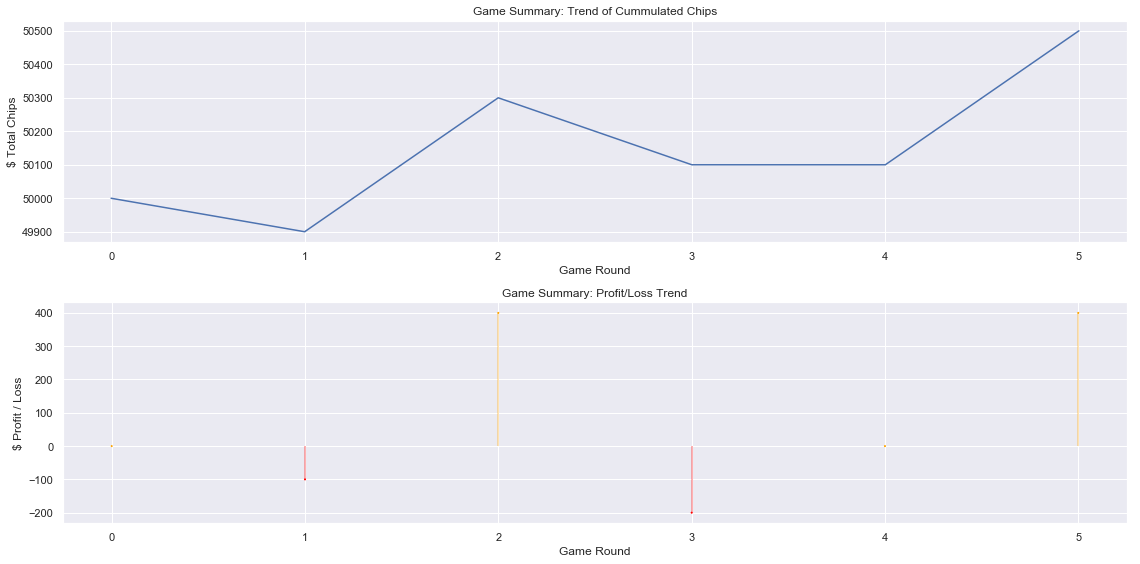

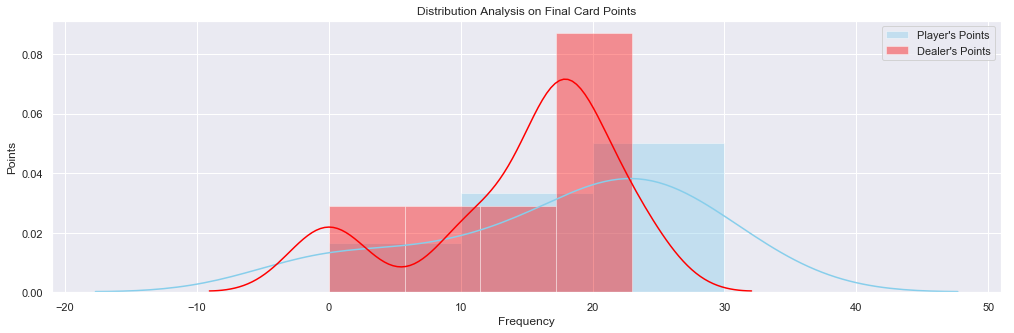

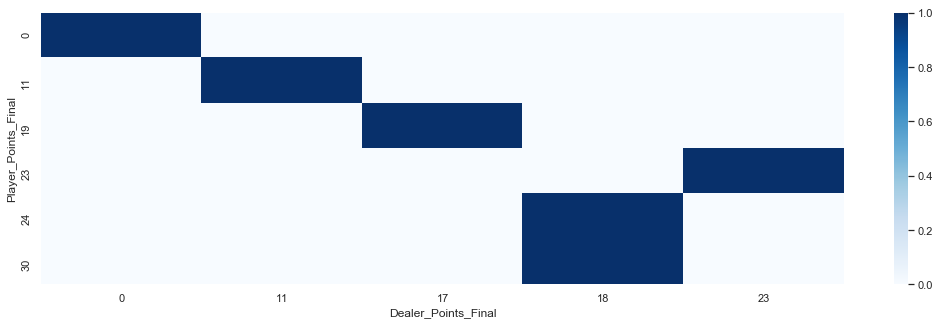

In [6]:
def game_summary(total_chips = total_chips, LnP = LnP, bid_lst = bid_lst,player_pts_lst=player_pts_lst):
    df = pd.DataFrame(columns=["Total_Chips",'Profit&Loss'])
    df['Total_Chips'] = total_chips
    df['Profit&Loss'] = LnP
    df['Bid_input'] = bid_lst
    df['Player_Points_Final'] = player_pts_lst
    df['Dealer_Points_Final'] = deal_pts_lst
    df['Result'] = df['Profit&Loss'].apply(lambda x : "Win" if x > 0 else ( "Lose" if x <0 else "Draw" ))
    df['Natural_win'] = abs(df['Profit&Loss']) / df['Bid_input']>1
    
    nat_win = df[df['Natural_win']==True]['Natural_win'].count()
    overall = (len(df)-1) 
    no_of_lose = df[df['Result']=="Lose"]['Result'].count()
    no_of_win = df[df['Result']=="Win"]['Result'].count()
    no_of_draw = df[df['Result']=="Draw"]['Result'].count() -1
    initial_chp = df['Total_Chips'][0]
    final_chp = df['Total_Chips'][len(df)-1]
    earning = df['Profit&Loss'].sum()


    print("   ======================= GAME SUMMARY =======================")
    print('\n')
    print(f'   Number of games       : {overall}        Winning Probability: {(no_of_win *100 / overall):.2f} %')
    print(f'   Number of games WON   : {no_of_win}         Initial Chips      : $ {initial_chp}')
    print(f'   Number of games LOST  : {no_of_lose}         Final Chips        : $ {final_chp}')
    print(f'   Number of games DRAW  : {no_of_draw}         Total Earning/Loss : $ {earning}')
    print(f'   Number of Natural WIN : {nat_win}')
    
    ## Plot Graph
    
    fig, ax = plt.subplots(2,1,figsize = (16,8))
    sns.set()
    a = ax.flatten()

    y1 = df['Total_Chips']
    y2= df['Profit&Loss']
    x2 = list(df.index)
    
    if len(x2)>100:
        x3 = []
    else: x3 = x2
    
    a[0].plot(y1)
    ax[0].set_xticks(x3)

    a[0].set_title("Game Summary: Trend of Cummulated Chips", loc='center')
    a[0].set_xlabel('Game Round')
    a[0].set_ylabel('$ Total Chips')

    my_color=np.where(y2>=0, 'orange', 'red')
    plt.vlines(x=x2, ymin=0, ymax=y2, color=my_color, alpha=0.4)
    plt.scatter(x2, y2, color=my_color, s=1, alpha=1)
    ax[1].set_xticks(x3)

    a[1].set_title("Game Summary: Profit/Loss Trend", loc='center')
    a[1].set_xlabel('Game Round')
    a[1].set_ylabel('$ Profit / Loss')
    
    
    fig2, ax2 = plt.subplots(figsize = (17,5))
    sns.distplot( df["Player_Points_Final"] , color="skyblue", label="Player's Points")
    sns.distplot( df["Dealer_Points_Final"] , color="red", label="Dealer's Points")
    ax2.set_title('Distribution Analysis on Final Card Points')
    ax2.set_ylabel("Points")
    ax2.set_xlabel("Frequency")
    
    fig3, ax3 = plt.subplots(figsize = (18,5))
    sns.heatmap(pd.crosstab(df['Player_Points_Final'],df['Dealer_Points_Final']), cmap = "Blues")
    
    fig.tight_layout()
    ax2.legend()
    plt.show()
    
    return df

df = game_summary(total_chips = total_chips, LnP = LnP, bid_lst = bid_lst,player_pts_lst=player_pts_lst)

### Enjoy Gambling!